# TCEQ Data Processor
This notebook serves to import the raw TCEQ data and combine it under one datafile.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

## Data Import
While not pretty, the following cell imports data from each of the csv files, combines them, and then saves the newly processed file. The import follows this process:
1. import data file for one pollutant from a specific CAMS station for one year
2. continue to import data for the same pollutant from the specific CAMS, combining years along the way
3. import data similar to above for a second pollutant at the same CAMS station (if it exists)
4. combine pollutant data from all years from a specific CAMS station and combine it with the overall dataframe
5. continue steps 1-4 until all CAMS stations have been exhausted

In [93]:
overall_df = pd.DataFrame() # final dataframe
for cam in ['171','1068','1605']:
    cam_df = pd.DataFrame() # dataframe with data from single cams station
    for pollutant in ['PM2p5','O3','NOx','NO']:
        pollutant_df = pd.DataFrame() # dataframe with data from one pollutant from one cams station
        for file in os.listdir('../data/raw/tceq/'):
            # getting file specifics from name
            file_fields = file.split()
            cams = file_fields[1]
            if cams == cam:
                pollutant_long = file_fields[2]
                # renaming pollutant
                if pollutant_long == 'PM-2.5':
                    pollutant_short = 'PM2p5'
                elif pollutant_long == 'Ozone':
                    pollutant_short = 'O3'
                elif pollutant_long == 'Nitrogen':
                    pollutant_short = 'NOx'
                elif pollutant_long == 'Nitric':
                    pollutant_short = 'NO'
                else:
                    pollutant_short = 'Na'
                # importing data and reformatting
                if pollutant_short == pollutant:
                    # some files have 4 lines of useless text, others have 5
                    try:
                        df = pd.read_csv(f'../data/raw/tceq/{file}',skiprows=4)
                        df = df.melt(id_vars='Date')
                    except KeyError:
                        df = pd.read_csv(f'../data/raw/tceq/{file}',skiprows=5)
                        df = df.melt(id_vars='Date')
                    # getting datetime index
                    df['datetime'] = df['Date']+' '+df['variable']
                    df['datetime'] = pd.to_datetime(df['datetime'])
                    df.set_index('datetime',inplace=True)
                    df.drop(['Date','variable'],axis=1,inplace=True)
                    df.sort_index(inplace=True)
                    # creating newly named value column and losing the old
                    df[pollutant+' '+cams] = pd.to_numeric(df['value'],errors='coerce')
                    df.drop(['value'],axis=1,inplace=True)
                        
                    pollutant_df = pd.concat([pollutant_df,df])
                    
        if len(pollutant_df) > 0:
            pollutant_df.sort_index(inplace=True)
            cam_df = pd.concat([cam_df,pollutant_df],axis=1,join='outer')
            
    overall_df = pd.concat([overall_df,cam_df],axis=1,join='outer')
    
overall_df.to_csv('../data/processed/tceq-all.csv')

## Visual Check
To make sure that everything was combined correctly

In [80]:
import matplotlib.pyplot as plt

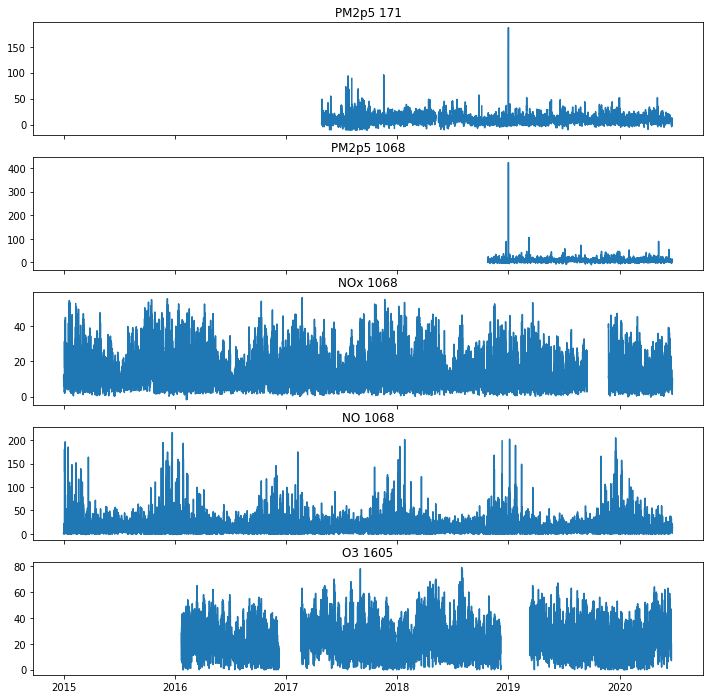

In [92]:
fig,ax = plt.subplots(5,1,figsize=(12,12),sharex='col')
for i in range(len(overall_df.columns)):
    ax[i].plot(overall_df.index,overall_df.iloc[:,i])
    ax[i].set_title(overall_df.columns[i])
    
plt.subplots_adjust(hspace=0.2)